In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

import warnings
warnings.filterwarnings('ignore')

from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import MinMaxScaler,StandardScaler

from imblearn.over_sampling import RandomOverSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score, auc, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

import shap

In [172]:
cd C:\Users\mifab\Documents\GitHub\-remote-healthcare-monitoring

C:\Users\mifab\Documents\GitHub\-remote-healthcare-monitoring


## Activity Processing

### Load Data

In [173]:
df_Activity=pd.read_csv("./Dataset/Activity.csv")
df_Activity['date']=pd.to_datetime(df_Activity['date']).dt.floor("h")
df_Activity['n']=1
df_Activity.head()

,patient_id,location_name,date,n
0,0697d,Fridge Door,2019-06-28 13:00:00,1
1,0697d,Kitchen,2019-06-28 13:00:00,1
2,0697d,Front Door,2019-06-28 13:00:00,1
3,0697d,Bedroom,2019-06-28 13:00:00,1
4,0697d,Fridge Door,2019-06-28 13:00:00,1


### Transform

In [174]:
df_Activity_pivoted=df_Activity.groupby(by=['patient_id','date','location_name'])['n'].count().unstack('location_name')
df_Activity_pivoted=df_Activity_pivoted.fillna(0)
df_Activity_pivoted=df_Activity_pivoted.reset_index(drop=False)
df_Activity_pivoted['date']=df_Activity_pivoted['date'].dt.floor("d")
df_Activity_pivoted=df_Activity_pivoted.groupby(by=['patient_id','date']).agg(['sum','std','mean','max'])
df_Activity_pivoted.columns = df_Activity_pivoted.columns.map('|'.join).str.strip('|')
df_Activity_pivoted=df_Activity_pivoted.reset_index(drop=False)
df_Activity_pivoted.head()

,patient_id,date,Back Door|sum,Back Door|std,Back Door|mean,Back Door|max,Bathroom|sum,Bathroom|std,Bathroom|mean,Bathroom|max,...,Hallway|mean,Hallway|max,Kitchen|sum,Kitchen|std,Kitchen|mean,Kitchen|max,Lounge|sum,Lounge|std,Lounge|mean,Lounge|max
0,0697d,2019-06-28,14.0,3.405877,1.400000,11.0,7.0,1.636392,0.700000,5.0,...,4.000000,9.0,106.0,5.253570,10.600000,20.0,80.0,5.597619,8.00,16.0
1,0697d,2019-06-29,2.0,0.323381,0.111111,1.0,11.0,1.649916,0.611111,6.0,...,3.166667,11.0,120.0,5.509350,6.666667,16.0,117.0,5.823381,6.50,21.0
2,0697d,2019-06-30,4.0,0.410391,0.200000,1.0,14.0,2.250146,0.700000,10.0,...,2.850000,10.0,119.0,5.124503,5.950000,17.0,103.0,4.295346,5.15,16.0
3,099bc,2019-05-15,12.0,1.229273,1.200000,3.0,17.0,1.567021,1.700000,5.0,...,3.200000,7.0,71.0,6.723921,7.100000,19.0,6.0,0.699206,0.60,2.0
4,099bc,2019-05-16,14.0,1.625455,0.700000,6.0,42.0,2.693071,2.100000,12.0,...,2.500000,7.0,104.0,6.287833,5.200000,24.0,9.0,0.998683,0.45,4.0


## Physiology Processing

### Load Data

In [175]:
df_Physiology=pd.read_csv("./Dataset/Physiology.csv")
df_Physiology.date=pd.to_datetime(df_Physiology.date).dt.date
df_Physiology.head()

,patient_id,date,device_type,value,unit
0,0697d,2019-06-28,Body Temperature,36.072,Cel
1,0697d,2019-06-28,Body Temperature,35.831,Cel
2,0697d,2019-06-28,Body Temperature,35.831,Cel
3,0697d,2019-06-28,Systolic blood pressure,165.000,mm[Hg]
4,0697d,2019-06-28,Diastolic blood pressure,82.000,mm[Hg]


### Transform

In [176]:
df_Physiology_pivoted=df_Physiology.groupby(by=['patient_id','date','device_type'])['value'].max().unstack('device_type').rename_axis(columns=None).reset_index()
df_Physiology_pivoted.head()

,patient_id,date,Body Temperature,Body weight,Diastolic blood pressure,Heart rate,O/E - muscle mass,Skin Temperature,Systolic blood pressure,Total body water
0,0697d,2019-06-28,36.599,86.3,82.0,42.0,64.5,NaN,165.0,50.6
1,0697d,2019-06-29,37.257,86.1,80.0,62.0,64.6,NaN,168.0,51.2
2,0697d,2019-06-30,36.779,NaN,83.0,55.0,NaN,NaN,158.0,NaN
3,099bc,2019-05-15,40.876,53.3,88.0,99.0,39.8,NaN,141.0,54.0
4,099bc,2019-05-16,37.045,52.7,78.0,71.0,NaN,NaN,152.0,NaN


## labels Processing

### Load

In [177]:
df_label=pd.read_csv("./Dataset/labels.csv")
df_label.date=pd.to_datetime(df_label.date).dt.date
df_label.head()

,patient_id,date,type
0,c55f8,2019-04-04,Blood pressure
1,16f4b,2019-04-08,Blood pressure
2,16f4b,2019-04-11,Agitation
3,ec812,2019-04-12,Blood pressure
4,16f4b,2019-04-14,Agitation


### Transform

In [178]:
df_label=df_label[df_label.type=='Agitation']
df_label=df_label.rename(columns={"type": "label"})
df_label.head()

,patient_id,date,label
2,16f4b,2019-04-11,Agitation
4,16f4b,2019-04-14,Agitation
5,16f4b,2019-04-15,Agitation
6,16f4b,2019-04-16,Agitation
11,16f4b,2019-04-21,Agitation


## Outer Join

In [179]:
df_Activity_pivoted['date']=pd.to_datetime(df_Activity_pivoted['date'])
df_Physiology_pivoted['date']=pd.to_datetime(df_Physiology_pivoted['date'])
df_label['date']=pd.to_datetime(df_label['date'])

df_join=df_Physiology_pivoted.merge(df_Activity_pivoted,
                                               how='outer',
                                               on=['patient_id','date']).merge(df_label,
                            how='outer',
                            on=['patient_id','date'])     
df_join['label']= df_join['label'].fillna(value='Normal')
df_join.head()

,patient_id,date,Body Temperature,Body weight,Diastolic blood pressure,Heart rate,O/E - muscle mass,Skin Temperature,Systolic blood pressure,Total body water,...,Hallway|max,Kitchen|sum,Kitchen|std,Kitchen|mean,Kitchen|max,Lounge|sum,Lounge|std,Lounge|mean,Lounge|max,label
0,0697d,2019-06-28,36.599,86.3,82.0,42.0,64.5,NaN,165.0,50.6,...,9.0,106.0,5.253570,10.600000,20.0,80.0,5.597619,8.00,16.0,Normal
1,0697d,2019-06-29,37.257,86.1,80.0,62.0,64.6,NaN,168.0,51.2,...,11.0,120.0,5.509350,6.666667,16.0,117.0,5.823381,6.50,21.0,Normal
2,0697d,2019-06-30,36.779,NaN,83.0,55.0,NaN,NaN,158.0,NaN,...,10.0,119.0,5.124503,5.950000,17.0,103.0,4.295346,5.15,16.0,Normal
3,099bc,2019-05-15,40.876,53.3,88.0,99.0,39.8,NaN,141.0,54.0,...,7.0,71.0,6.723921,7.100000,19.0,6.0,0.699206,0.60,2.0,Normal
4,099bc,2019-05-16,37.045,52.7,78.0,71.0,NaN,NaN,152.0,NaN,...,7.0,104.0,6.287833,5.200000,24.0,9.0,0.998683,0.45,4.0,Normal


### Impute and normalise per ID and using global average if all NAs

In [180]:
gc=[]
for i in df_join['patient_id'].unique():
    other_columns = []
    numeric_columns = []
    numeric_columns_global_avg = {}
    for c in df_join.columns:
        if c in df_join.select_dtypes(include='number'):
            numeric_columns.append(c)
            numeric_columns_global_avg.update({c:df_join[c].mean(skipna=True)})
        else:
            other_columns.append(c)
    subset_df=df_join[df_join['patient_id']==i]
    data_numeric = subset_df[numeric_columns]
    data_categorical = pd.DataFrame(subset_df[other_columns])
    for d in data_numeric.columns:
        if data_numeric[d].isnull().all():
            data_numeric[d]=numeric_columns_global_avg[d]
    imp = IterativeImputer(max_iter=10, random_state=0)
    scaler = MinMaxScaler()
    data_numeric = pd.DataFrame(scaler.fit_transform(imp.fit_transform(data_numeric)),
                                columns = data_numeric.columns,
                                index=data_numeric.index)  
    data_joined = pd.concat([data_categorical,data_numeric], axis = 1)
    gc.append(data_joined)

In [181]:
imputed_normalised_physiological=pd.concat(gc, ignore_index=True)
imputed_normalised_physiological.head()

,patient_id,date,label,Body Temperature,Body weight,Diastolic blood pressure,Heart rate,O/E - muscle mass,Skin Temperature,Systolic blood pressure,...,Hallway|mean,Hallway|max,Kitchen|sum,Kitchen|std,Kitchen|mean,Kitchen|max,Lounge|sum,Lounge|std,Lounge|mean,Lounge|max
0,0697d,2019-06-28,Normal,0.000000,1.000000,0.666667,0.000000,0.000000,0.0,0.700000,...,1.000000,0.00,0.000000,0.335373,1.000000,1.000000,0.000000,0.852253,1.000000,0.000
1,0697d,2019-06-29,Normal,1.000000,0.000000,0.000000,1.000000,1.000000,0.0,1.000000,...,0.275362,1.00,1.000000,1.000000,0.154122,0.000000,1.000000,1.000000,0.473684,1.000
2,0697d,2019-06-30,Normal,0.273556,0.137036,1.000000,0.650000,0.862908,0.0,0.000000,...,0.000000,0.50,0.928571,0.000000,0.000000,0.250000,0.621622,0.000000,0.000000,0.000
3,099bc,2019-05-15,Normal,1.000000,0.823529,0.202161,1.000000,0.971429,0.0,0.098473,...,0.788406,0.35,0.525926,0.794285,1.000000,0.703704,0.171429,0.179040,0.325714,0.125
4,099bc,2019-05-16,Normal,0.149612,0.470588,0.088184,0.243243,0.242926,0.0,0.246485,...,0.615942,0.35,0.770370,0.732458,0.732394,0.888889,0.257143,0.255724,0.244286,0.250


## Train models

### Split X and Y

### Impute response variable

In [182]:
X=imputed_normalised_physiological.sort_values(by='date').reset_index(drop=True)
label_encoder = LabelEncoder()
X.label = label_encoder.fit_transform(X.label)

### Initialise collectors and vars

In [224]:
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import IsolationForest

In [240]:
window = pd.Timedelta('7D')
kfold = 5 
rseed=42
end_date = X.date.tail(1).values[0]
keys=['date','patient_id']
model_df = []
accuracy = []
sensitivity = []
specificity  = []
f1 = []

In [241]:
for k in range(kfold):
    split = end_date - window
    train_X = X.loc[(pd.to_datetime(X.date)-pd.to_datetime(split))<=pd.Timedelta(0,'D')]
    test_X = X.loc[((pd.to_datetime(X.date)-pd.to_datetime(split))>pd.Timedelta(0,'D'))
                   &((pd.to_datetime(X.date)-pd.to_datetime(split))<=window)]
    end_date = split

    train_X_n = train_X.drop(keys,axis=1)
    test_X_n = test_X.drop(keys,axis=1)
    
    train_y = train_X_n.label.values
    test_y = test_X_n.label.values
    
    train_X = train_X_n.drop('label',axis=1).values
    test_X = test_X_n.drop('label',axis=1).values        

    ros = RandomOverSampler(random_state=rseed)
    train_X, train_y = ros.fit_resample(train_X, train_y)

    models = {
        "GB": GradientBoostingClassifier(n_estimators=20,min_samples_leaf=1,random_state=rseed),
        "MLP":   MLPClassifier(hidden_layer_sizes=(128,128),max_iter=300,activation='tanh',alpha=0.001,early_stopping=True,random_state=rseed),
        "LR":  LogisticRegression(max_iter=5000,random_state=rseed),
        "GNB":  GaussianNB(),
        "GPC":  GaussianProcessClassifier(random_state=rseed),
        "DT": DecisionTreeClassifier(random_state=rseed),
        "RF": RandomForestClassifier(random_state=rseed),
        "GB": GradientBoostingClassifier(random_state=rseed),
        "KNN": KNeighborsClassifier(n_neighbors=1),
        "SVM": SVC()
    }
    
    for model, model_launch in models.items():
        
        model_initiated = model_launch
        model_initiated.fit(train_X, train_y)
        predictions = model_initiated.predict(test_X)
        
        model_df.append(model)

        accuracy.append(accuracy_score(test_y, predictions))
        sensitivity.append(recall_score(test_y, predictions, pos_label=1)*100)
        specificity.append(recall_score(test_y, predictions, pos_label=0)*100)
        f1.append(f1_score(test_y, predictions))
                
        scores_df_stand = pd.DataFrame({'Model':model_df,
                                  'Accuracy': accuracy, 
                                  'Sensitivity': sensitivity,
                                  'Specificity': specificity,
                                  'F1':f1}).sort_values(by='Accuracy', ascending=False)

## Results

### Average 5 fold cross validation

In [242]:
scores_df_stand_g=scores_df_stand.groupby(by='Model').mean().sort_values(by='Specificity', ascending=False).reset_index(drop=False)

scores_df_stand_g
(scores_df_stand_g.style
  .background_gradient(subset=['Accuracy','Sensitivity','Specificity','F1'])
  .highlight_max(subset=['Accuracy','Sensitivity','Specificity','F1'], color='gold')
  .set_caption('Model Performance with average 5 fold Validation')
  .format({'Accuracy': "{:.2%}",
           'Precision': "{:.2%}",
           'Recall': "{:.2%}",
           'F1': "{:.2%}"
          }))


,Model,Accuracy,Sensitivity,Specificity,F1
0,GNB,71.44%,71.201715,78.573781,82.52%
1,LR,79.57%,80.054903,70.276680,88.09%
2,MLP,87.26%,88.828896,57.743742,92.93%
3,GPC,88.77%,90.894632,46.874177,93.87%
4,SVM,91.83%,94.623368,35.932148,95.63%
5,GB,92.30%,95.704184,27.302372,95.93%
6,KNN,93.39%,96.934032,23.932806,96.51%
7,DT,91.93%,95.854810,12.984190,95.73%
8,RF,95.04%,99.406884,8.672596,97.43%


### Shap Values

### Get feature names

In [258]:
train_y = train_X_n.label
test_y = test_X_n.label
train_X = train_X_n.drop('label',axis=1)
test_X = test_X_n.drop('label',axis=1)  

### Fit model

In [259]:
clf3 = models['LR']
clf3.fit(train_X, train_y)
explainer = shap.LinearExplainer(clf3, masker=shap.maskers.Impute(data=train_X))
shap_values = explainer.shap_values(test_X)
colors = ["b", "r"]           
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

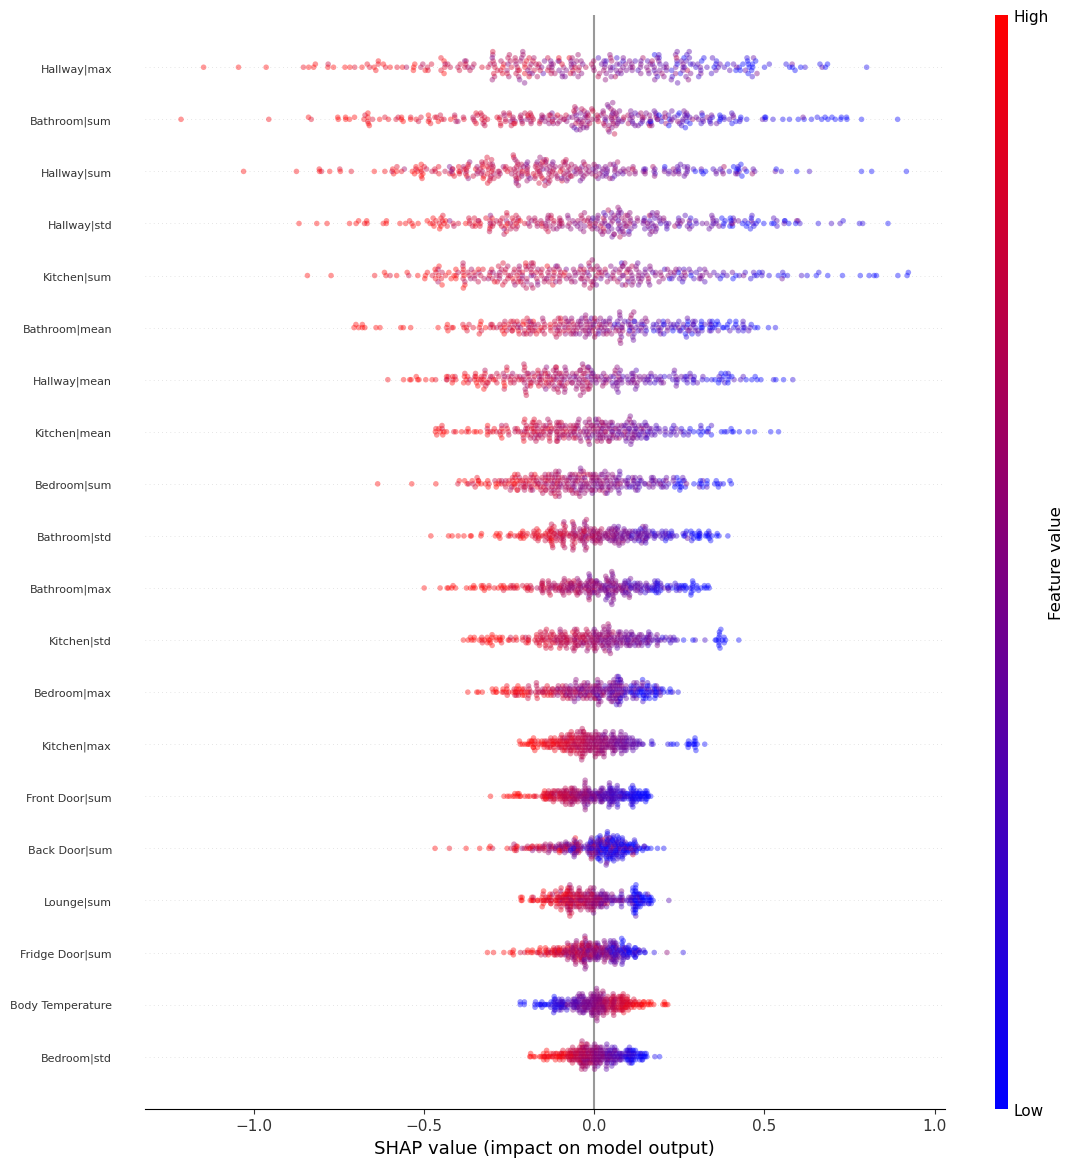

In [260]:
shap.summary_plot(shap_values, test_X,cmap=cmap,alpha=0.4, show=False)
fig = plt.gcf()
fig.set_figheight(12)
fig.set_figwidth(14)
ax = plt.gca()
ax.yaxis.set_tick_params(labelsize=8)
plt.show()

## Conclusions

We were able to create an accurate predictor of Agitation based on patients activitites and physiological signals with a linar regression model,
with similar performance to that reported in the literature, and the SHAP values also indicate that 'Activity' data is more relevant than 'Physiological' data when predicting Agitation. 